# Noisy Coin Example

## Introduction

## Preamble

We turn on the ``division`` feature first of all, since this is just a plain good idea when working in Python 2.x, as it is a more sensible default for scientific computing and is the default in Python 3.x anyway.

In [1]:
from __future__ import division

IPython's ``%matplotlib`` magic command is quite useful. With the ``inline`` argument, all plots will be made a part of the notebook.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['figure.figsize'] = 8, 8
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

Next, we need to import from *Qinfer*.

In [3]:
# We need distributions to model priors.
from qinfer import distributions
# The noisy coin model has already been implmented, so let's import it here.
from qinfer.test_models import NoisyCoinModel
# Next, we need to import the sequential Monte Carlo updater class.
from qinfer.smc import SMCUpdater
# We'll be demonstrating approximate likelihood evaluation (ALE) as well.
from qinfer import ale

In [4]:
import numpy as np
import time
from scipy.special import betaln, gammaln

## Sequential Monte Carlo

It's helpful to define a few constants, as we'll need to refer to them over and over below.

In [11]:
N_PARTICLES = 5000
N_EXP = 250
N_TRIALS = 100

Let's make a model to play with, using the prior $p \sim \mathrm{Uni}(0, 1)$.

In [12]:
prior = distributions.UniformDistribution([0, 1])
model = NoisyCoinModel()

We need to allocate an array to hold performance data. A record array is a rather convienent structure for doing so. First, let's define the fields in this array,

In [13]:
performance_dtype = [
    ('outcome', 'i1'),
    ('est_mean', 'f8'), ('est_cov_mat', 'f8'),
    ('true_err', 'f8'), ('resample_count', 'i8'),
    ('elapsed_time', 'f8'),
    ('like_count', 'i8'), ('sim_count', 'i8'),
]

... and then the array itself.

In [14]:
performance = np.empty((N_TRIALS, N_EXP), dtype=performance_dtype)

In [15]:
true_params = np.empty((N_TRIALS, model.n_modelparams))

Now, we run the experiments!

In [16]:
ALPHA = 0.1
BETA = 0.8
expparams = np.array([(ALPHA, BETA)], dtype=model.expparams_dtype)

In [17]:
for idx_trial in range(N_TRIALS):
    
    # First, make new updaters using the constructors
    # defined above.
    updater = SMCUpdater(model, N_PARTICLES, prior)
    
    # Sample true set of modelparams.
    truemp = prior.sample()
    true_params[idx_trial, :] = truemp

    # Now loop over experiments, updating each of the
    # updaters with the same data, so that we can compare
    # their estimation performance.
    for idx_exp in range(N_EXP):
        
        # Make a short hand for indexing the current simulation
        # and experiment.
        idxs = np.s_[idx_trial, idx_exp]
        
        # Start by simulating and recording the data.
        outcome = model.simulate_experiment(truemp, expparams)
        performance['outcome'][idxs] = outcome
    
        # Reset the like_count and sim_count
        # properties so that we can count how many were used
        # by this update. Note that this is a hack;
        # an appropriate method should be added to
        # Simulatable.
        model._sim_count = 0
        model._call_count = 0
            
        # Time the actual update.
        tic = toc = None
        tic = time.time()
        updater.update(outcome, expparams)
        performance[idxs]['elapsed_time'] = time.time() - tic
        
        # Record the performance of this updater.
        est_mean = updater.est_mean()
        performance[idxs]['est_mean'] = est_mean
        performance[idxs]['true_err'] = np.abs(est_mean - truemp) ** 2
        performance[idxs]['est_cov_mat'] = updater.est_covariance_mtx()
        performance[idxs]['resample_count'] = updater.resample_count
        performance[idxs]['like_count'] = model.call_count
        performance[idxs]['sim_count'] = model.sim_count
       

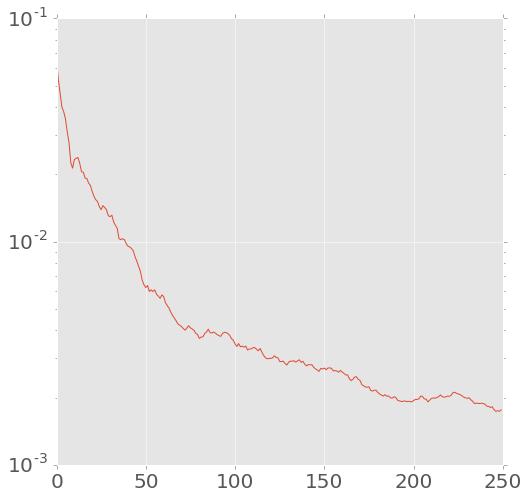

In [19]:
plt.semilogy(np.mean(performance['true_err'], axis=0))
